In [ ]:
Finite-Horizon PMF Simulations
Reproducibility archive for:
"Finite-Horizon Freedom Maximization in Directed Acyclic Growth"

Environment:
Python 3.x
No external dependencies beyond numpy, matplotlib
Random seed fixed where indicated.


In [2]:
import math
import random
from functools import lru_cache
from itertools import combinations, chain
from collections import deque, defaultdict

# ============================================================
# Finite-horizon PMF simulation for:
# K(d, Δ, kmax): bounded-degree + bounded-memory + local antichain
#
# State representation:
#   G is encoded by parents_list: a tuple of tuples
#   parents_list[i] = tuple(sorted(parents of node i))
# Nodes are labeled 0..n-1 in insertion order.
# New node is always added as a new maximal element (no outgoing edges).
# ============================================================

def make_initial_state(d=3, Delta=3, kmax=2, n_roots=1):
    """
    Start with n_roots isolated nodes (no edges).
    """
    parents_list = tuple(() for _ in range(n_roots))
    return (d, Delta, kmax, parents_list)

def n_nodes(G):
    return len(G[3])

def build_children(parents_list):
    children = [[] for _ in range(len(parents_list))]
    outdeg = [0] * len(parents_list)
    for v, P in enumerate(parents_list):
        for p in P:
            children[p].append(v)
            outdeg[p] += 1
    return children, outdeg

def maximal_elements(parents_list):
    children, _ = build_children(parents_list)
    return [v for v in range(len(parents_list)) if len(children[v]) == 0]

def depth_to_boundary(parents_list):
    """
    depth(p, ∂G) = length of shortest directed path from p to some maximal element.
    Compute distances from boundary backwards using parent links.
    If a node cannot reach boundary (shouldn't happen in finite DAG with maximal nodes), dist=+inf.
    """
    n = len(parents_list)
    dist = [math.inf] * n
    boundary = maximal_elements(parents_list)
    q = deque(boundary)
    for b in boundary:
        dist[b] = 0

    # reverse BFS: from node -> its parents
    while q:
        v = q.popleft()
        for p in parents_list[v]:
            if dist[p] > dist[v] + 1:
                dist[p] = dist[v] + 1
                q.append(p)
    return dist

def is_ancestor(parents_list, a, b):
    """
    Return True iff a ≺ b (a is an ancestor of b).
    Since b's parents point backward, we can DFS upward from b.
    """
    if a == b:
        return False
    stack = list(parents_list[b])
    seen = set()
    while stack:
        x = stack.pop()
        if x == a:
            return True
        if x in seen:
            continue
        seen.add(x)
        stack.extend(parents_list[x])
    return False

def is_antichain(parents_list, P):
    """
    Optional redundancy filter: chosen parents must be pairwise incomparable.
    i.e., for distinct p,q in P: not(p≺q) and not(q≺p).
    """
    P = list(P)
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            p, q = P[i], P[j]
            if is_ancestor(parents_list, p, q) or is_ancestor(parents_list, q, p):
                return False
    return True

def adm_moves(G, use_antichain=True):
    """
    Generate admissible one-step moves e ∈ Adm(G).
    Here a move is represented simply by the parent-set tuple P (sorted).
    """
    d, Delta, kmax, parents_list = G
    n = len(parents_list)

    # compute outdegree and depth-to-boundary
    _, outdeg = build_children(parents_list)
    depth = depth_to_boundary(parents_list)

    # eligible parents: recent enough AND have spare capacity
    eligible = [v for v in range(n) if depth[v] <= d and outdeg[v] < Delta]

    moves = []
    # choose parent sets P with 1 <= |P| <= kmax
    for r in range(1, min(kmax, len(eligible)) + 1):
        for P in combinations(eligible, r):
            if use_antichain and not is_antichain(parents_list, P):
                continue
            moves.append(tuple(P))
    return moves

def apply_move(G, P):
    """
    Add new node v_new with parent set P, add edges p -> v_new for p in P.
    """
    d, Delta, kmax, parents_list = G
    P = tuple(sorted(P))
    new_parents_list = parents_list + (P,)
    return (d, Delta, kmax, new_parents_list)

# -----------------------------
# Φ_H recursion (exact) + PMF
# -----------------------------

@lru_cache(maxsize=None)
def phi_cached(G, H, use_antichain=True):
    """
    Exact Φ_H(G) = number of admissible extension sequences of length H.
    Note: use_antichain must be constant for caching consistency.
    """
    if H == 0:
        return 1
    moves = adm_moves(G, use_antichain=use_antichain)
    # Assumption A requires nonempty; but constraints might dead-end for some parameters:
    if not moves:
        return 0
    total = 0
    for P in moves:
        G2 = apply_move(G, P)
        total += phi_cached(G2, H-1, use_antichain=use_antichain)
    return total

def pmf_step(G, H, use_antichain=True, tie_break="random"):
    """
    Deterministic PMF_H step:
      Ψ_H(G,P) = Φ_{H-1}(G⊕P)
    Choose P maximizing Ψ.
    """
    moves = adm_moves(G, use_antichain=use_antichain)
    if not moves:
        return G, None, None

    scored = []
    for P in moves:
        G2 = apply_move(G, P)
        score = phi_cached(G2, H-1, use_antichain=use_antichain) if H >= 1 else 1
        scored.append((score, P))

    max_score = max(s for s, _ in scored)
    best = [P for s, P in scored if s == max_score]

    if tie_break == "random":
        P_star = random.choice(best)
    else:
        P_star = best[0]

    return apply_move(G, P_star), P_star, max_score

def softmax_step(G, H, alpha=1.0, use_antichain=True):
    """
    Probabilistic PMF kernel:
      P(P | G) ∝ exp(alpha * Ψ_H(G,P))
    """
    moves = adm_moves(G, use_antichain=use_antichain)
    if not moves:
        return G, None, None

    scores = []
    for P in moves:
        G2 = apply_move(G, P)
        scores.append(phi_cached(G2, H-1, use_antichain=use_antichain) if H >= 1 else 1)

    m = max(scores)
    weights = [math.exp(alpha * (s - m)) for s in scores]  # stable
    Z = sum(weights)
    probs = [w / Z for w in weights]

    P = random.choices(moves, weights=probs, k=1)[0]
    return apply_move(G, P), P, probs

def run_sim(G0, steps=20, H=4, mode="det", alpha=1.0, use_antichain=True):
    """
    mode:
      "det"  -> deterministic PMF (random tie-break by default)
      "soft" -> softmax PMF
      "rand" -> uniform random admissible move
    """
    G = G0
    hist = []
    for t in range(steps):
        moves = adm_moves(G, use_antichain=use_antichain)
        if not moves:
            hist.append((t, None, "dead_end"))
            break

        if mode == "det":
            G, P, score = pmf_step(G, H, use_antichain=use_antichain, tie_break="random")
            hist.append((t, P, ("maxPsi", score)))
        elif mode == "soft":
            G, P, probs = softmax_step(G, H, alpha=alpha, use_antichain=use_antichain)
            hist.append((t, P, ("softmax", None)))
        elif mode == "rand":
            P = random.choice(moves)
            G = apply_move(G, P)
            hist.append((t, P, ("rand", None)))
        else:
            raise ValueError("mode must be one of: det, soft, rand")
    return G, hist

# -----------------------------
# Quick demo (edit parameters)
# -----------------------------
random.seed(7)

G0 = make_initial_state(d=3, Delta=3, kmax=2, n_roots=2)

# Clear cache if you change antichain flag / rules a lot
phi_cached.cache_clear()

G_end, history = run_sim(G0, steps=15, H=3, mode="det", use_antichain=False)


print("Final n =", n_nodes(G_end))
print("First 10 steps (t, parents_of_new_node, info):")
for row in history[:10]:
    print(row)

# Also show remaining branching at end
moves_end = adm_moves(G_end, use_antichain=True)
print("Adm(G_end) size =", len(moves_end))


Final n = 17
First 10 steps (t, parents_of_new_node, info):
(0, (1,), ('maxPsi', 60))
(1, (0,), ('maxPsi', 150))
(2, (3,), ('maxPsi', 315))
(3, (2,), ('maxPsi', 588))
(4, (4,), ('maxPsi', 976))
(5, (3, 6), ('maxPsi', 1548))
(6, (5,), ('maxPsi', 2326))
(7, (2,), ('maxPsi', 3411))
(8, (8,), ('maxPsi', 4885))
(9, (9,), ('maxPsi', 6684))
Adm(G_end) size = 115


Completed in 413.88 sec for 40 PMF + 40 Random runs.

Metric: adm
  PMF   mean=287.725  med=291.000  min=266.000  max=303.000
  RAND  mean=126.575  med=128.000  min=82.000  max=158.000

Metric: depth
  PMF   mean=6.225  med=6.000  min=5.000  max=7.000
  RAND  mean=8.175  med=8.000  min=6.000  max=11.000

Metric: boundary
  PMF   mean=7.750  med=8.000  min=6.000  max=10.000
  RAND  mean=7.000  med=7.000  min=4.000  max=10.000

Metric: n
  PMF   mean=27.000  med=27.000  min=27.000  max=27.000
  RAND  mean=27.000  med=27.000  min=27.000  max=27.000

Metric: avg_outdeg
  PMF   mean=1.177  med=1.185  min=1.037  max=1.296
  RAND  mean=1.580  med=1.556  min=1.481  max=1.704

Metric: max_outdeg
  PMF   mean=2.175  med=2.000  min=2.000  max=3.000
  RAND  mean=3.000  med=3.000  min=3.000  max=3.000


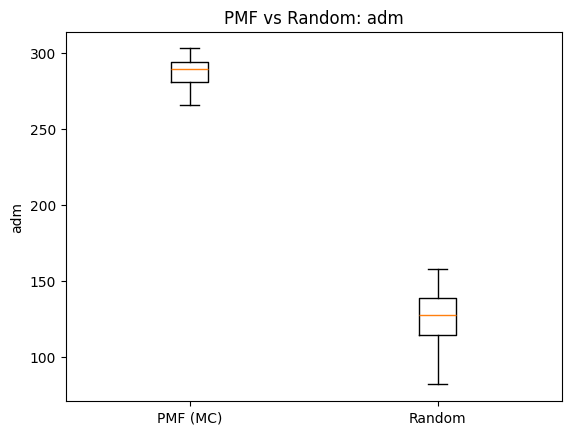

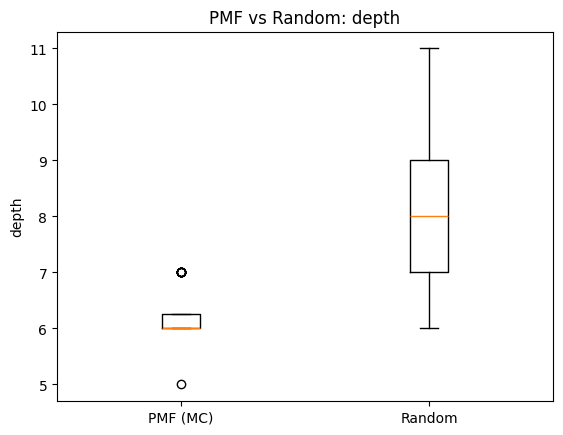

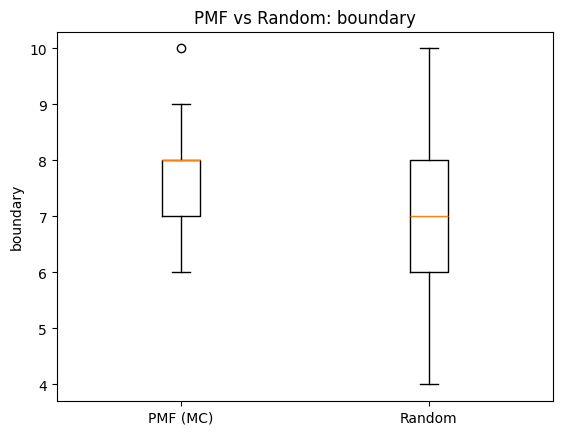

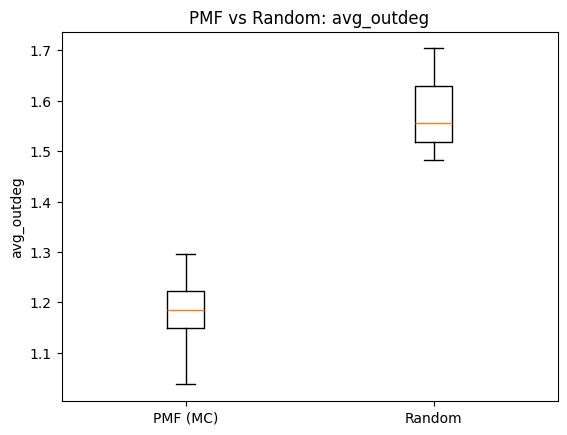

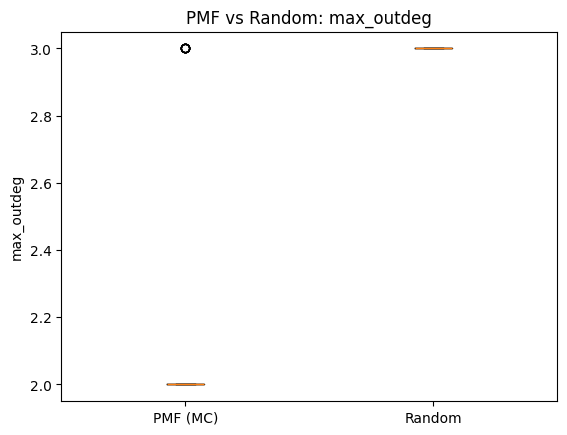

In [4]:
import math, random, time
from itertools import combinations
from collections import deque
import matplotlib.pyplot as plt

# ============================================================
# State: (d, Delta, kmax, parents_list)
# parents_list[i] = tuple(sorted(parents of node i))
# ============================================================

def make_initial_state(d=3, Delta=3, kmax=2, n_roots=2):
    parents_list = tuple(() for _ in range(n_roots))
    return (d, Delta, kmax, parents_list)

def n_nodes(G):
    return len(G[3])

def children_outdeg(parents_list):
    n = len(parents_list)
    children = [[] for _ in range(n)]
    outdeg = [0]*n
    for v, P in enumerate(parents_list):
        for p in P:
            children[p].append(v)
            outdeg[p] += 1
    return children, outdeg

def maximal_elements(parents_list):
    children, _ = children_outdeg(parents_list)
    return [v for v in range(len(parents_list)) if len(children[v]) == 0]

def depth_to_boundary(parents_list):
    n = len(parents_list)
    dist = [10**9]*n
    boundary = maximal_elements(parents_list)
    q = deque(boundary)
    for b in boundary:
        dist[b] = 0
    while q:
        v = q.popleft()
        dv = dist[v]
        for p in parents_list[v]:
            if dist[p] > dv + 1:
                dist[p] = dv + 1
                q.append(p)
    return dist

def is_ancestor(parents_list, a, b):
    if a == b:
        return False
    stack = list(parents_list[b])
    seen = set()
    while stack:
        x = stack.pop()
        if x == a:
            return True
        if x in seen:
            continue
        seen.add(x)
        stack.extend(parents_list[x])
    return False

def is_antichain(parents_list, P):
    P = list(P)
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            p, q = P[i], P[j]
            if is_ancestor(parents_list, p, q) or is_ancestor(parents_list, q, p):
                return False
    return True

def adm_moves(G, use_antichain=True):
    d, Delta, kmax, parents_list = G
    n = len(parents_list)
    _, outdeg = children_outdeg(parents_list)
    depth = depth_to_boundary(parents_list)

    eligible = [v for v in range(n) if depth[v] <= d and outdeg[v] < Delta]
    moves = []
    rmax = min(kmax, len(eligible))
    for r in range(1, rmax+1):
        for P in combinations(eligible, r):
            if use_antichain and not is_antichain(parents_list, P):
                continue
            moves.append(tuple(P))
    return moves

def apply_move(G, P):
    d, Delta, kmax, parents_list = G
    P = tuple(sorted(P))
    return (d, Delta, kmax, parents_list + (P,))

# ============================================================
# Metrics (cheap + informative)
# ============================================================

def longest_chain_length(parents_list):
    # DP since edges go from parent -> child, but we store parents.
    n = len(parents_list)
    dp = [0]*n  # length ending at node
    # nodes are in insertion order; parents always < child, so topological
    for v in range(n):
        if not parents_list[v]:
            dp[v] = 1
        else:
            dp[v] = 1 + max(dp[p] for p in parents_list[v])
    return max(dp) if dp else 0

def boundary_size(parents_list):
    return len(maximal_elements(parents_list))

def outdeg_stats(parents_list):
    _, outdeg = children_outdeg(parents_list)
    if not outdeg:
        return 0, 0, 0
    return sum(outdeg)/len(outdeg), max(outdeg), sum(1 for x in outdeg if x==0)/len(outdeg)

# ============================================================
# Monte Carlo estimator of Φ_H (rollouts)
# We estimate Φ_H(G) up to multiplicative constant using:
#   Φ ≈ Π_t |Adm(G_t)|
# along random admissible rollout paths.
# ============================================================

def phi_mc_estimate(G, H, R=64, use_antichain=True):
    if H <= 0:
        return 1.0
    vals = []
    for _ in range(R):
        Gt = G
        prod = 1.0
        for _h in range(H):
            moves = adm_moves(Gt, use_antichain=use_antichain)
            if not moves:
                prod = 0.0
                break
            prod *= len(moves)
            P = random.choice(moves)
            Gt = apply_move(Gt, P)
        vals.append(prod)
    # robust average (median) to reduce variance
    vals.sort()
    return vals[len(vals)//2]

# ============================================================
# PMF-approx step:
# Evaluate a subset of moves (M candidates) and choose max estimated Φ_{H-1}(G⊕e)
# ============================================================

def pmf_mc_step(G, H, R=64, M=30, use_antichain=True):
    moves = adm_moves(G, use_antichain=use_antichain)
    if not moves:
        return G, None, None
    # subsample candidates if too many
    if len(moves) > M:
        cand = random.sample(moves, M)
    else:
        cand = moves

    bestP, bestScore = None, -1.0
    h2 = max(H-1, 0)
    for P in cand:
        G2 = apply_move(G, P)
        score = phi_mc_estimate(G2, h2, R=R, use_antichain=use_antichain) if h2>0 else 1.0
        if score > bestScore:
            bestScore, bestP = score, P
    return apply_move(G, bestP), bestP, bestScore

def random_step(G, use_antichain=True):
    moves = adm_moves(G, use_antichain=use_antichain)
    if not moves:
        return G, None
    P = random.choice(moves)
    return apply_move(G, P), P

# ============================================================
# Run trajectories + many runs comparison
# ============================================================

def run_traj(G0, steps=25, mode="pmf", H=5, R=64, M=30, use_antichain=True):
    G = G0
    for t in range(steps):
        if mode == "pmf":
            G, P, _ = pmf_mc_step(G, H=H, R=R, M=M, use_antichain=use_antichain)
            if P is None:
                break
        elif mode == "rand":
            G, P = random_step(G, use_antichain=use_antichain)
            if P is None:
                break
        else:
            raise ValueError("mode must be pmf or rand")
    return G

def collect_metrics(G, use_antichain=True):
    d, Delta, kmax, parents_list = G
    adm = len(adm_moves(G, use_antichain=use_antichain))
    depth = longest_chain_length(parents_list)
    bsz = boundary_size(parents_list)
    avg_out, max_out, frac0 = outdeg_stats(parents_list)
    return {
        "n": len(parents_list),
        "adm": adm,
        "depth": depth,
        "boundary": bsz,
        "avg_outdeg": avg_out,
        "max_outdeg": max_out,
        "frac_outdeg0": frac0,
    }

def many_runs(n_runs=50, seed=7, d=3, Delta=3, kmax=2, n_roots=2,
              steps=25, H=5, R=64, M=30, use_antichain=True):
    random.seed(seed)
    pmf_metrics = []
    rnd_metrics = []
    t0 = time.time()

    for i in range(n_runs):
        G0 = make_initial_state(d=d, Delta=Delta, kmax=kmax, n_roots=n_roots)

        Gp = run_traj(G0, steps=steps, mode="pmf", H=H, R=R, M=M, use_antichain=use_antichain)
        Gr = run_traj(G0, steps=steps, mode="rand", use_antichain=use_antichain)

        pmf_metrics.append(collect_metrics(Gp, use_antichain=use_antichain))
        rnd_metrics.append(collect_metrics(Gr, use_antichain=use_antichain))

    dt = time.time() - t0
    return pmf_metrics, rnd_metrics, dt

def summarize(metrics, key):
    vals = [m[key] for m in metrics]
    vals_sorted = sorted(vals)
    mean = sum(vals)/len(vals)
    med = vals_sorted[len(vals)//2]
    return mean, med, min(vals), max(vals)

# =======================
# RUN EXPERIMENT (edit)
# =======================
pmf, rnd, dt = many_runs(
    n_runs=40,
    seed=20,
    d=3, Delta=3, kmax=2, n_roots=2,
    steps=25,
    H=5,          # lookahead horizon (conceptual)
    R=24,         # rollouts per candidate move (accuracy vs speed)
    M=15,         # candidate moves evaluated per step (speed vs optimality)
    use_antichain=True
)

print(f"Completed in {dt:.2f} sec for {len(pmf)} PMF + {len(rnd)} Random runs.")

for key in ["adm","depth","boundary","n","avg_outdeg","max_outdeg"]:
    pm = summarize(pmf, key)
    rm = summarize(rnd, key)
    print(f"\nMetric: {key}")
    print(f"  PMF   mean={pm[0]:.3f}  med={pm[1]:.3f}  min={pm[2]:.3f}  max={pm[3]:.3f}")
    print(f"  RAND  mean={rm[0]:.3f}  med={rm[1]:.3f}  min={rm[2]:.3f}  max={rm[3]:.3f}")

# Plots (boxplot-style)
def plot_compare(key, title=None):
    a = [m[key] for m in pmf]
    b = [m[key] for m in rnd]
    plt.figure()
    plt.boxplot([a,b], tick_labels=["PMF (MC)", "Random"])
    plt.title(title or key)
    plt.ylabel(key)
    plt.show()

for key in ["adm","depth","boundary","avg_outdeg","max_outdeg"]:
    plot_compare(key, title=f"PMF vs Random: {key}")


In [5]:
Hs = [2,3,4,5]
results = []

for H in Hs:
    pmf, rnd, dt = many_runs(
        n_runs=30,
        seed=12,
        d=3, Delta=3, kmax=2, n_roots=2,
        steps=20,
        H=H,
        R=24,
        M=15,
        use_antichain=True
    )
    pmf_adm_mean = sum(m["adm"] for m in pmf)/len(pmf)
    rnd_adm_mean = sum(m["adm"] for m in rnd)/len(rnd)
    pmf_depth_mean = sum(m["depth"] for m in pmf)/len(pmf)
    rnd_depth_mean = sum(m["depth"] for m in rnd)/len(rnd)
    results.append((H, pmf_adm_mean, rnd_adm_mean, pmf_depth_mean, rnd_depth_mean, dt))
    print("H", H, "done in", round(dt,2), "sec")

print("\nH  PMF_adm  RAND_adm  PMF_depth  RAND_depth  time(s)")
for row in results:
    print(f"{row[0]:<2} {row[1]:8.2f} {row[2]:9.2f} {row[3]:10.2f} {row[4]:11.2f} {row[5]:8.2f}")


H 2 done in 34.62 sec
H 3 done in 72.26 sec
H 4 done in 117.64 sec
H 5 done in 166.96 sec

H  PMF_adm  RAND_adm  PMF_depth  RAND_depth  time(s)
2    200.17     90.67       5.07        7.67    34.62
3    196.67     91.13       5.17        7.47    72.26
4    195.40     90.13       5.30        7.47   117.64
5    195.20     90.53       5.37        7.27   166.96


In [6]:
Deltas = [2,3,4,5]
results = []

for Delta in Deltas:
    pmf, rnd, dt = many_runs(
        n_runs=30,
        seed=12,
        d=3, Delta=Delta, kmax=2, n_roots=2,
        steps=20,
        H=3,
        R=24,
        M=15,
        use_antichain=True
    )
    pmf_adm = sum(m["adm"] for m in pmf)/len(pmf)
    rnd_adm = sum(m["adm"] for m in rnd)/len(rnd)
    results.append((Delta, pmf_adm, rnd_adm, dt))
    print("Delta", Delta, "done in", round(dt,2), "sec")

print("\nDelta  PMF_adm  RAND_adm")
for row in results:
    print(f"{row[0]:<6} {row[1]:9.2f} {row[2]:10.2f}")


Delta 2 done in 50.04 sec
Delta 3 done in 73.66 sec
Delta 4 done in 73.7 sec
Delta 5 done in 71.39 sec

Delta  PMF_adm  RAND_adm
2         126.20      30.27
3         196.67      91.13
4         212.70     130.13
5         216.67     143.80


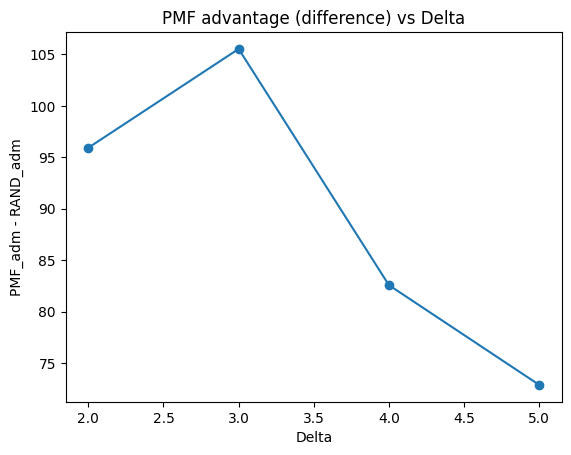

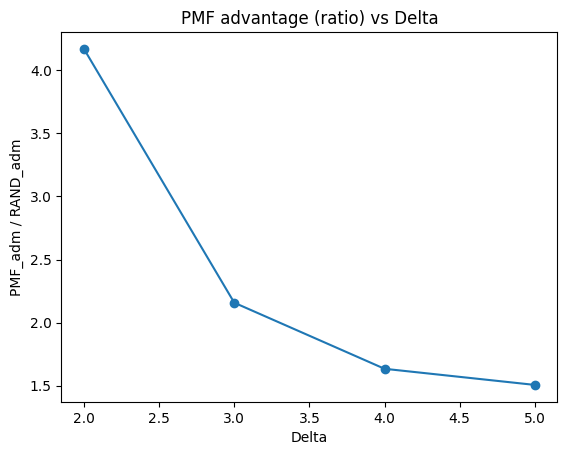

In [7]:
import matplotlib.pyplot as plt

deltas = [2,3,4,5]
pmf_vals = [126.20,196.67,212.70,216.67]
rnd_vals = [30.27,91.13,130.13,143.80]

diff = [p-r for p,r in zip(pmf_vals, rnd_vals)]
ratio = [p/r for p,r in zip(pmf_vals, rnd_vals)]

plt.figure()
plt.plot(deltas, diff, marker='o')
plt.title("PMF advantage (difference) vs Delta")
plt.xlabel("Delta")
plt.ylabel("PMF_adm - RAND_adm")
plt.show()

plt.figure()
plt.plot(deltas, ratio, marker='o')
plt.title("PMF advantage (ratio) vs Delta")
plt.xlabel("Delta")
plt.ylabel("PMF_adm / RAND_adm")
plt.show()


d 1 done in 60.3 sec
d 2 done in 71.1 sec
d 3 done in 72.78 sec
d 4 done in 73.03 sec
d 5 done in 73.03 sec

d   PMF_adm  RAND_adm  PMF_depth  RAND_depth  time(s)
1    165.87     26.27       5.67       10.00    60.30
2    195.60     81.50       5.23        7.27    71.10
3    196.67     91.13       5.17        7.47    72.78
4    196.67     92.87       5.37        6.97    73.03
5    195.93     93.50       5.40        6.83    73.03


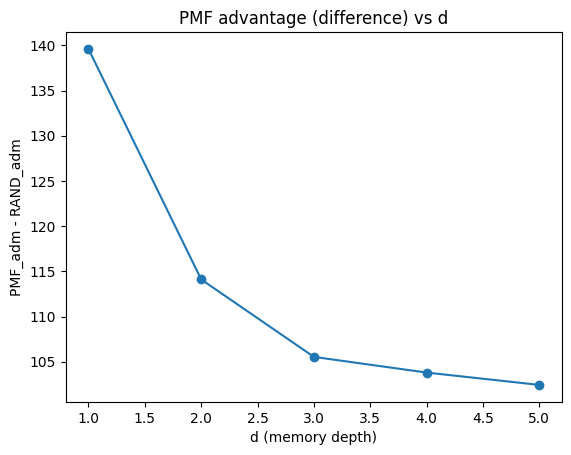

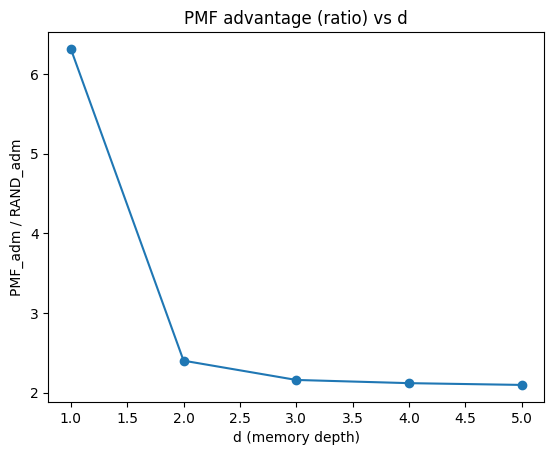

In [8]:
import matplotlib.pyplot as plt

ds = [1,2,3,4,5]
results = []

for d in ds:
    pmf, rnd, dt = many_runs(
        n_runs=30,
        seed=12,
        d=d, Delta=3, kmax=2, n_roots=2,
        steps=20,
        H=3,
        R=24,
        M=15,
        use_antichain=True
    )
    pmf_adm = sum(m["adm"] for m in pmf)/len(pmf)
    rnd_adm = sum(m["adm"] for m in rnd)/len(rnd)
    pmf_depth = sum(m["depth"] for m in pmf)/len(pmf)
    rnd_depth = sum(m["depth"] for m in rnd)/len(rnd)

    results.append((d, pmf_adm, rnd_adm, pmf_depth, rnd_depth, dt))
    print("d", d, "done in", round(dt,2), "sec")

print("\nd   PMF_adm  RAND_adm  PMF_depth  RAND_depth  time(s)")
for row in results:
    print(f"{row[0]:<2} {row[1]:8.2f} {row[2]:9.2f} {row[3]:10.2f} {row[4]:11.2f} {row[5]:8.2f}")

# Plots: advantage vs d
d_vals   = [r[0] for r in results]
pmf_adm  = [r[1] for r in results]
rnd_adm  = [r[2] for r in results]

diff = [p-r for p,r in zip(pmf_adm, rnd_adm)]
ratio = [p/r for p,r in zip(pmf_adm, rnd_adm)]

plt.figure()
plt.plot(d_vals, diff, marker='o')
plt.title("PMF advantage (difference) vs d")
plt.xlabel("d (memory depth)")
plt.ylabel("PMF_adm - RAND_adm")
plt.show()

plt.figure()
plt.plot(d_vals, ratio, marker='o')
plt.title("PMF advantage (ratio) vs d")
plt.xlabel("d (memory depth)")
plt.ylabel("PMF_adm / RAND_adm")
plt.show()
